In [1]:
#@title Imports

%%capture
!pip install rtree
!pip install pygeos
!pip install geopandas
!pip install rasterstats
import ee
import numpy as np
import pandas as pd
import geopandas as gpd
import os
from google.colab import drive
from rasterstats import zonal_stats
import rasterio
from pyproj import CRS
from sklearn import neighbors

%pylab inline

Load and save shapefiles in a Drive folder, which also needs to be authenticated.

In [2]:
# @title Mount google drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
# Copy data to local cache
!cp -r /gdrive/'Shared drives'/'Sunbird AI'/Projects/'GIZ Mini-grid Identification'/Data .


cp: cannot open '/gdrive/Shared drives/Sunbird AI/Projects/GIZ Mini-grid Identification/Data/Sources of data.gdoc' for reading: Operation not supported


In [4]:
drive_data_absolute_dir = './Data/'

Load shapefile containing the villages of interest in the study.

In [5]:
villages = gpd.read_file('Data/Sunbird_Lamwo/Village_Boundaries_UBOS_2020.shp')

In [6]:
villages.head(3)

,ID,V_OBJECTID,Shape_Leng,Shape_Area,addr_dname,addr_cname,addr_sname,addr_pname,addr_vname,addr_rname,REA_PROJEC,NRECA_MP,geometry
0,5500895,32615,1540.032051,1.485227e+05,Lamwo,Lamwo,Agoro,Ngacino,Special Area,Northern,F,F,"POLYGON ((33.02180 3.80975, 33.02515 3.80996, ..."
1,5500896,32616,42482.085300,8.355897e+07,Lamwo,Lamwo,Agoro,Ngacino,Grazing Land,Northern,F,F,"POLYGON ((32.96090 3.84951, 32.97234 3.85664, ..."
2,5500897,32617,6762.484374,2.436672e+06,Lamwo,Lamwo,Agoro,Ngacino,Irumo,Northern,F,F,"POLYGON ((33.00190 3.82770, 33.00515 3.83096, ..."


#NES status of villages

Get the status of each village according to the National Electrification Strategy. Possible statuses can be:

- Currently connected to grid
- Planned extension to grid
- Current minigrid site
- Planned minigrid site
- Planned solar home system

In [7]:
def read_shapefile(path_in_drive):
  gdf = gpd.read_file(
      os.path.join(drive_data_absolute_dir, path_in_drive)
  ).to_crs('EPSG:4326')
  return gdf

# Existing minigrid sites
existing_minigrid_sites = read_shapefile(
    'Sunbird_Lamwo/Existing_MG_Sites_REA_2021.shp')
villages['existing_minigrid'] = villages.ID.isin(
    villages.sjoin(existing_minigrid_sites, how='right').ID_left)

# Candidate minigrid sites
candidate_minigrid_sites = read_shapefile(
    'Sunbird_Lamwo/Candidates_Off-Grid_MG_GEOSIM.shp')
villages['candidate_minigrid'] = villages.ID.isin(
    villages.sjoin(candidate_minigrid_sites, how='right').ID_left)  

# Candidate solar home system sites
candidate_solar_home_system_sites = read_shapefile(
    'Sunbird_Lamwo/Candidates_SHS_GEOSIM.shp')
villages['candidate_solar_home_system'] = villages.ID.isin(
    villages.sjoin(candidate_solar_home_system_sites, how='right').ID_left)

# Candidate grid extension villages
candidate_grid_extension_villages = read_shapefile(
    'Sunbird_Lamwo/Grid_Consolidated_Existing-GEOSIM.shp')
villages['candidate_grid_extension'] = villages.ID.isin(
    villages.sjoin(candidate_grid_extension_villages, how='right').ID_left)

In [8]:
villages.shape

(411, 17)

# Wind and vegetation data

For vegetation, we compute the minimum vegetation index over a 12 month period (to account for areas under cultivation), and compute a national percentile.

We use wind data from [ERA5-Land](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_HOURLY) which gives hourly data at 11km resolution, three months behind real time.

We access remote sensing data from Earth Engine, and need to authenticate to the service.

In [9]:
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=e1sN_Q2pnlHotz7WwZ-xeRcS-YIJj5xWKIlRYlSCgIQ&tc=c_1FcTOiNPIAggp6Py-7YLpOonxxebR9WnNYNVHP-ck&cc=0mdupf1nBHyl3rTPBZAA9rvdOUvVAcvkSNGub9WHXWs

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1ARtbsJoXBE8nK9jk2kb9p935_5ICdVSTPYmbgfTR2GLCEvfkq8I9yiHcQrA

Successfully saved authorization token.


In [10]:
country = read_shapefile('administrative areas/UGA Country.gpkg')
min_lon, min_lat, max_lon, max_lat = country.geometry[0].bounds
region = ee.Geometry.Rectangle(min_lon, min_lat, max_lon, max_lat)

In [11]:
collection = 'ECMWF/ERA5_LAND/HOURLY'

def wind_speed(image):
  u_squared = image.select(['u_component_of_wind_10m']).pow(
      ee.Image.constant(2))
  v_squared = image.select(['v_component_of_wind_10m']).pow(
      ee.Image.constant(2))
  sum_squared = u_squared.add(v_squared)
  speed = sum_squared.pow(ee.Image.constant(0.5))
  return speed

dataset = (ee.ImageCollection(collection)
           .filter(ee.Filter.date('2021-05-01', '2022-05-01'))
           .select(['u_component_of_wind_10m', 'v_component_of_wind_10m'])
           .map(wind_speed)
           .mean())

image = dataset.clipToBoundsAndScale(geometry=region, scale=10_000)
url = ee.Image.getDownloadURL(image, params={'format': 'GEO_TIFF'})

!wget {url} -O wind_speed.tif

--2022-11-01 17:15:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f1788878248d71eb9a493a8144911929-39aa8a2cc3f21008495018330795ddbc:getPixels
Resolving earthengine.googleapis.com (earthengine.googleapis.com)... 142.251.2.95, 142.250.141.95, 74.125.137.95, ...
Connecting to earthengine.googleapis.com (earthengine.googleapis.com)|142.251.2.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26826 (26K) [image/tiff]
Saving to: ‘wind_speed.tif’

wind_speed.tif      100%[===================>]  26.20K  --.-KB/s    in 0.001s  

2022-11-01 17:16:24 (17.1 MB/s) - ‘wind_speed.tif’ saved [26826/26826]



In [12]:
villages['mean_wind_speed'] = pd.DataFrame(
    zonal_stats(
        vectors=villages['geometry'], 
        raster='wind_speed.tif', 
        nodata=-1,
        stats='mean',
        all_touched=True
    )
)['mean']

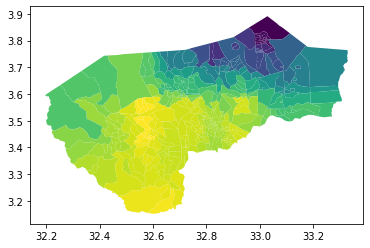

In [13]:
villages.plot(column='mean_wind_speed')

Vegetation index data

In [14]:
# MOD13A2.061 Terra Vegetation Indices 16-Day Global 1km
collection = 'MODIS/061/MOD13A2' 

dataset = (ee.ImageCollection(collection)
           .filter(ee.Filter.date('2021-06-01', '2022-06-01'))
           .select('NDVI')
           .min())

image = dataset.clipToBoundsAndScale(geometry=region, scale=10_000)
url = ee.Image.getDownloadURL(image, params={'format': 'GEO_TIFF'})

!wget {url} -O ndvi.tif

--2022-11-01 17:16:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1ea9fc1bb3b4a56cd3b1a68cc68f119a-d732994c61bc11c014ea7c4053726e8a:getPixels
Resolving earthengine.googleapis.com (earthengine.googleapis.com)... 142.251.2.95, 142.250.141.95, 74.125.137.95, ...
Connecting to earthengine.googleapis.com (earthengine.googleapis.com)|142.251.2.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8078 (7.9K) [image/tiff]
Saving to: ‘ndvi.tif’

ndvi.tif            100%[===================>]   7.89K  --.-KB/s    in 0s      

2022-11-01 17:16:28 (77.0 MB/s) - ‘ndvi.tif’ saved [8078/8078]



In [15]:
villages['vegetation_index'] = pd.DataFrame(
    zonal_stats(
        vectors=villages['geometry'], 
        raster='ndvi.tif', 
        nodata=-1,
        stats='median',
        all_touched=True
    )
)['median']

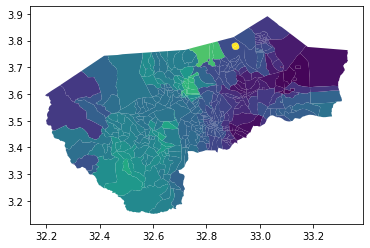

In [16]:
villages.plot(column='vegetation_index')

Get the protected areas within each village, so that we aren't recommending biomass as a fuel source from forest reserves and such like.

In [17]:
protected_areas = read_shapefile(
    'protected areas/WDPA_WDOECM_Aug2022_Public_UGA.gdb')
protected_areas['full_name'] = protected_areas.apply(
    lambda row: row['NAME'] + ' ' + row['DESIG'], axis=1)

villages['contains_protected_area'] = villages.geometry.apply(
    lambda x: x.intersects(protected_areas.geometry.any()))
join = villages.sjoin(protected_areas, how='right')
join = join[~join.ID.isnull()]
villages['protected_area_name'] = villages.ID.apply(
    lambda x: ', '.join(list(join[join.ID == x].full_name))
)
villages['contains_protected_area'] = (villages['protected_area_name'] != '')

Compute the NDVI value as a percentile nationally, so that we can make statements about the vegetation level in a village compared to the rest of the country.

In [18]:
villages_file = os.path.join(
        drive_data_absolute_dir,
        'administrative areas/UGA villages 2011.gpkg')

with rasterio.open('ndvi.tif') as ndvi_file:
  ndvi_array = ndvi_file.read().astype(np.float32).squeeze(0)
  ndvi_affine = ndvi_file.transform

# Exclude water areas
ndvi_array[ndvi_array < 0] = -1

all_villages_ndvi = pd.DataFrame(
    zonal_stats(
        vectors=villages_file,
        raster=ndvi_array,
        affine=ndvi_affine, 
        nodata=-1,
        stats='median',
        all_touched=True
    )
)['median']

all_villages_ndvi = np.array(sorted(list(all_villages_ndvi)))

ndvi_percentiles = np.array(
    [-np.inf] + [a[0] for a in np.array_split(all_villages_ndvi, 99)])

def ndvi_value_to_percentile(x):
  return np.where(x >= ndvi_percentiles)[0][-1]

villages['vegetation_percentile'] = (villages['vegetation_index']
                                     .apply(ndvi_value_to_percentile))

In [19]:
villages.shape

(411, 22)

# Information about settlement size and density

We want to find the number of buildings within a certain radius, so we need to reproject the coordinates from longitude/latitude.

In [20]:
minigrid_radius_meters = 1000
size_of_permanent_building = 36 # 36 sqm

buildings = read_shapefile('buildings/buildings_lamwo.gpkg')
crs = CRS.from_dict({'proj': 'utm', 'zone': 36, 'north': True})
buildings = buildings.to_crs(crs)
buildings.geometry = buildings.centroid
xy = np.stack((buildings.geometry.y, buildings.geometry.x)).transpose()
nn = neighbors.radius_neighbors_graph(xy, minigrid_radius_meters)
buildings['num_buildings_in_radius'] = [len(nn[i,:].indices)
                                        for i in range(len(buildings))]
buildings['permanent_buildings'] = buildings['area_in_meters'].apply(
    lambda x: 1 if x > size_of_permanent_building else 0)

In [21]:
buildings_with_village = buildings.sjoin(villages.to_crs(crs),
                                         how="right",
                                         predicate='intersects')
building_details = buildings_with_village[
    ['ID', 'num_buildings_in_radius', 'permanent_buildings']].groupby(by='ID').agg(
        {'ID':['count'], 'permanent_buildings':['sum'], 'num_buildings_in_radius':['max']})
building_details.columns = ['num_of_buildings', 'num_of_permanent_buildings', 'num_buildings_in_radius']

villages = pd.merge(villages, building_details, on='ID')
villages['num_buildings_in_radius'] = villages['num_buildings_in_radius'].fillna(0).astype('Int64')
villages['num_of_permanent_buildings'] = villages['num_of_permanent_buildings'].fillna(0).astype('Int64')

In [22]:
# villages.plot(column='num_buildings_in_radius')

In [23]:
villages['any_electrification_provision_in_NES'] = False

villages.loc[
    villages.query(
        'candidate_minigrid or candidate_solar_home_system '
        'or candidate_grid_extension or existing_minigrid'
    ).index,
    'any_electrification_provision_in_NES'] = True

villages['any_electrification_provision_in_NES'].value_counts()

True     348
False     63
Name: any_electrification_provision_in_NES, dtype: int64

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 1.0, 'Max number of buildings in any 1km radius, by NES category')

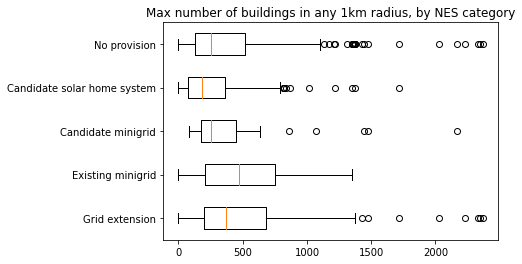

In [24]:
plt.boxplot([
    villages.query('candidate_grid_extension')['num_buildings_in_radius'],
    villages.query('existing_minigrid')['num_buildings_in_radius'],
    villages.query('candidate_minigrid')['num_buildings_in_radius'],
    villages.query('candidate_solar_home_system')['num_buildings_in_radius'],
    villages.query('any_electrification_provision_in_NES')['num_buildings_in_radius']
    ],
    labels=[
        'Grid extension', 'Existing minigrid', 'Candidate minigrid',
        'Candidate solar home system', 'No provision'],
    vert=False);
plt.title('Max number of buildings in any 1km radius, by NES category')

Create a json file with the details to be shown on the front end.

In [25]:
wind_speed_viability_threshold = 6.0
minigrid_buildings_high_threshold = 700
minigrid_buildings_low_threshold = 200

def village_row_to_dict(row):
  
  village_json = {}
  power_supply_analysis = []
  power_demand_analysis = []

  if row["vegetation_percentile"] > 0.75:
    power_supply_analysis.append({
        'source': 'biomass',
        'factor_in_favour': True,
        'detail': (
            'The vegetation index for this village is relatively high (greater '
            f'than {row["vegetation_percentile"]}% of villages nationwide).')
    })

  if row["contains_protected_area"]:
    power_supply_analysis.append({
        'source': 'biomass',
        'factor_in_favour': False,
        'detail': (
            'This village contains a protected area '
            f'({row["protected_area_name"]}) which should not be used for '
            'harvesting biomass.')
    })

  if row["mean_wind_speed"] < wind_speed_viability_threshold:
    power_supply_analysis.append({
        'source': 'wind',
        'factor_in_favour': False,
        'detail': (
            'The average annual wind speed in this location is '
            f'{row["mean_wind_speed"]:.1f} m/s, which is below a '
            'typical commercial viability threshold of '
            f'{wind_speed_viability_threshold:.0f} m/s.'
        )
    })

  if (row['num_buildings_in_radius'] > minigrid_buildings_high_threshold
      and not (row['candidate_grid_extension']
               or row['candidate_minigrid']
               or row['existing_minigrid'])):
    power_demand_analysis.append({
        'source': 'minigrid',
        'factor_in_favour': True,
        'detail': (
            f'There are {row["num_buildings_in_radius"]} buildings within '
            'a 1km radius, indicating that a solar minigrid would have a '
            'high number of potential connections.'
        )
    })

  if (row['num_buildings_in_radius'] < minigrid_buildings_low_threshold
      and not (row['candidate_grid_extension']
               or row['candidate_minigrid']
               or row['existing_minigrid'])):
    power_demand_analysis.append({
        'source': 'minigrid',
        'factor_in_favour': False,
        'detail': (
            f'There are {row["num_buildings_in_radius"]} buildings within '
            'a 1km radius, indicating that a solar minigrid would have a '
            'low number of potential connections.'
        )
    })

  result = {
      'power_supply_analysis': power_supply_analysis,
      'power_demand_analysis': power_demand_analysis,
  }

  result['ID'] = row['ID']
  result['latitude'] = row['geometry'].centroid.y
  result['longitude'] = row['geometry'].centroid.x
  result['district'] = row['addr_dname']
  result['subcounty'] = row['addr_sname']
  result['parish'] = row['addr_pname']
  result['village'] = row['addr_vname']
  result['max_num_buildings_in_1km_radius'] = row['num_buildings_in_radius']
  result['vegetation_percentile'] = row['vegetation_percentile']
  result['mean_wind_speed'] = round(row['mean_wind_speed'], 1)
  result['num_buildings'] = row['num_of_buildings']
  result['num_permanent_buildings'] = row['num_of_permanent_buildings']

  if row['candidate_grid_extension']:
    NES_category = 'Grid extension'
  elif row['existing_minigrid']:
    NES_category = 'Existing minigrid site'
  elif row['candidate_minigrid']:
    NES_category = 'Candidate minigrid site'
  else:
    NES_category = 'Candidate for solar home systems'
  
  result['NES_category'] = NES_category

  return result

analysis = villages.apply(village_row_to_dict, axis=1)

## Categorise any buildings which are known to be facilities

Taking data about the point locations of health, administrative facilities, and so on, attempt to match these to buildings in the dataset. 



In [26]:
!ls Data/buildings/facilities/*.shp

Data/buildings/facilities/Administrative_Offices.shp
Data/buildings/facilities/Commercial_Facilities.shp
Data/buildings/facilities/Drinking_Water.shp
Data/buildings/facilities/Education_Facilities.shp
Data/buildings/facilities/Energy_Facilities.shp
Data/buildings/facilities/Health_Facilities.shp
Data/buildings/facilities/Industrial_Parks.shp
Data/buildings/facilities/Religious_Facilities.shp


In [42]:
facility_shapefile_names = {
    'administrative': 'Administrative_Offices.shp',
    'commercial': 'Commercial_Facilities.shp',
    'school': 'Education_Facilities.shp',
    'health facility': 'Health_Facilities.shp',
}

Reload the buildings with polygon geometry (instead of points)

In [53]:
buildings = read_shapefile('buildings/buildings_lamwo.gpkg')
crs = CRS.from_dict({'proj': 'utm', 'zone': 36, 'north': True})
buildings = buildings.to_crs(crs)
buildings['category'] = None

In [ ]:
min_size_of_facility_building = 150
max_distance_from_reference_point = 100

for category in facility_shapefile_names.keys():
  facilities = gpd.read_file(
        f'Data/buildings/facilities/{facility_shapefile_names[category]}'
    ).set_crs('EPSG:21096').to_crs('+proj=utm +zone=36 +north +type=crs')
  facility_areas = facilities.buffer(max_distance_from_reference_point)
  facility_areas = gpd.GeoDataFrame(geometry=facility_areas)
  facility_buildings = gpd.sjoin(
      buildings, facility_areas, predicate='intersects')
  facility_buildings = facility_buildings.query(
      f'area_in_meters > {min_size_of_facility_building}')
  facility_buildings['category'] = category
  for i in list(facility_buildings.index):
    buildings.loc[i, 'category'] = category

In [56]:
gpkg_path = 'buildings_categorised.gpkg'
if os.path.exists(gpkg_path):
  print(f'Warning: the file {gpkg_path} already exists '
        'and will be appended to (not overwritten).')

buildings.to_file(
    'buildings_categorised.gpkg',
    driver='GPKG')

In [ ]:
import json
villages_json = list(analysis)

with open("villages.json", "w") as write_file:
    json.dump(villages_json, write_file, indent=4, sort_keys=True)